In [12]:
from randomDistricts import Hierarchy_2D
from gerrychain import (Graph, Partition, MarkovChain, tree,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from treelib import Node, Tree
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange

In [13]:
epsilon_split = {"equal": [0.2,0.2,0.2,0.2,0.2], 
                 "top_heavy": [1/2, 1/4, 1/12, 1/12, 1/12],
                 "mid_heavy": [1/12, 1/6, 1/2, 1/6, 1/12], 
                 "bottom_heavy": [1/12, 1/12, 1/12, 1/4, 1/2]}

In [14]:
def district_frag_scores(h, districts):
    num_districts = len(districts)
    frag_scores = np.zeros(num_districts)
    for i in tqdm(range(num_districts)):
        frag_scores[i] = h.assign_district_tree_variance(districts[i],eps=1, eps_splits=[np.sqrt(2)]*5)
    return frag_scores

In [15]:
def emperical_district_variances_non_neg(districts):
    vrs = {}
    num_districts = len(districts)
    for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy"]:
        df = pd.read_csv("../multi_attribute_toydown/results/noised_runs_1_{}.csv".format(split))
        pops = np.zeros((num_districts, 32))
        print(split)
        for j in range(num_districts):
            if j % 20 == 0: print("*", end="")
            pops[j] = df[df.GEOID.astype(str).apply(lambda i: bool(districts[j][i]))].groupby("run").sum().TOTPOP.values
        print() 
        vs = np.var(pops, axis=1)
        vrs[split] = vs
    return vrs

In [16]:
def emperical_district_variances_allow_neg(districts):
    vrs = {}
    num_districts = len(districts)
    for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy"]:
        df = pd.read_csv("../multi_attribute_toydown/results/noised_runs_allow_neg_1_{}.csv".format(split))
        pops = np.zeros((num_districts, 32))
        print(split)
        for j in range(num_districts):
            if j % 20 == 0: print("*", end="")
            pops[j] = df[df.GEOID.astype(str).apply(lambda i: bool(districts[j][i]))].groupby("run").sum().TOTPOP.values
        print() 
        vs = np.var(pops, axis=1)
        vrs[split] = vs
    return vrs

In [17]:
def analytical_district_variances(h, districts):
    vrs = {}
    num_districts = len(districts)
    for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy"]:
        print(split)
        vs = np.array([h.assign_district_tree_variance(dist,eps=1, 
                         eps_splits=epsilon_split[split]) for dist in districts])
        vrs[split] = vs
    return vrs

In [18]:
def district_data_frame(frag_scores, emperical_vars, analytical_vars):
    results = pd.DataFrame()
    for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy"]:
        results = results.append(pd.DataFrame(emperical_vars[split], 
                                              columns=["variance"]).assign(frag_score=frag_scores, 
                                                                           split=split, 
                                                                           analytical=False, 
                                                                           eps=1))
        results = results.append(pd.DataFrame(analytical_vars[split],
                                              columns=["variance"]).assign(frag_score=frag_scores, 
                                                                           split=split, 
                                                                           analytical=True, 
                                                                           eps=1))
    return results

In [19]:
with open("data/dallas_district_sample_202.p", "rb") as fin:
    og_districts = pickle.load(fin)

In [20]:
with open("data/dallas_hierarcy.p", "rb") as fin:
    h = pickle.load(fin)

In [21]:
tract_dists = np.load("sample_districts/100_recom_tract_parts_comp.npy", allow_pickle=True)[0]

In [22]:
tract_recom_frag_scores

array([100.12087578, 107.54732151, 100.61333043,  92.28122755,
       100.61333043,  84.80007576,  95.51897327,  92.83028577,
       105.33033044, 110.49261902,  85.3981904 ,  92.28122755,
        97.60199899, 106.22844758, 103.95485293, 107.54732151,
        90.61141148,  91.72839577, 110.08318295, 112.0926276 ,
        91.72839577, 103.48881329, 104.41711901,  85.99253147,
        91.17179041,  96.56803328, 108.40770295, 107.54732151,
        98.11332149, 107.97939902,  83.59252576, 107.11147044,
        96.04539006,  93.37557041,  99.62464757,  82.9830904 ,
        94.45481899, 109.66997331, 107.97939902,  93.37557041,
        94.98878292,  97.08690292, 106.22844758,  82.9830904 ,
        90.61141148,  88.90763326,  98.11332149,  90.04725898,
       105.7812758 ,  94.98878292,  90.04725898,  93.91708149,
       107.54732151,  91.17179041, 107.11147044,  87.75291326,
       105.7812758 , 107.54732151, 109.25299009, 113.63225903,
        90.04725898, 104.41711901,  94.98878292,  85.39

In [ ]:
tract_recom_frag_scores = district_frag_scores(h,tract_dists["dicts"])

 11%|█         | 42/399 [00:17<02:24,  2.47it/s]

In [ ]:
tract_emp_non_neg = emperical_district_variances_non_neg(tract_dists["dicts"])

In [ ]:
tract_emp_allow_neg = emperical_district_variances_allow_neg(tract_dists["dicts"])

In [ ]:
tract_analytical = analytical_district_variances(h, tract_dists["dicts"])

In [ ]:
tract_recom = district_data_frame(tract_recom_frag_scores, tract_emp, tract_analytical)

In [ ]:
# tract_recom.to_csv("data/recom_tract_dists.csv", index=False)

In [13]:
block_dists = np.load("sample_districts/100_recom_block_parts_comp.npy", allow_pickle=True)[0]

In [8]:
block_recom_frag_scores = district_frag_scores(h,block_dists["dicts"])

100%|██████████| 398/398 [02:39<00:00,  2.49it/s]


In [14]:
block_emp_allow_neg = emperical_district_variances_allow_neg(block_dists["dicts"])

equal
********************
top_heavy
********************
mid_heavy
********************
bottom_heavy
********************


In [51]:
block_emp_non_neg = emperical_district_variances_non_neg(block_dists["dicts"])

equal
********************
top_heavy
********************
mid_heavy
********************
bottom_heavy
********************


In [52]:
block_analytical = analytical_district_variances(h, block_dists["dicts"])

equal
top_heavy
mid_heavy
bottom_heavy


In [53]:
block_recom = district_data_frame(block_recom_frag_scores, block_emp, block_analytical)

In [57]:
block_recom.to_csv("data/recom_block_dists.csv", index=False)

In [15]:
block_bb_dists = np.load("sample_districts/400_squre_block_dists.npy", allow_pickle=True)[0]

In [93]:
block_bb_frag_scores = district_frag_scores(h,block_bb_dists["dicts"])

100%|██████████| 400/400 [02:43<00:00,  2.44it/s]


In [16]:
block_bb_emp_allow_neg = emperical_district_variances_allow_neg(block_bb_dists["dicts"])

equal
********************
top_heavy
********************
mid_heavy
********************
bottom_heavy
********************


In [94]:
block_bb_emp_non_neg = emperical_district_variances_non_neg(block_bb_dists["dicts"])

equal
********************
top_heavy
********************
mid_heavy
********************
bottom_heavy
********************


In [95]:
block_bb_analytical = analytical_district_variances(h, block_bb_dists["dicts"])

equal
top_heavy
mid_heavy
bottom_heavy


In [96]:
block_bb = district_data_frame(block_bb_frag_scores, block_bb_emp, block_bb_analytical)

In [97]:
block_bb

,variance,frag_score,split,analytical,eps
0,13217.190787,588.007074,equal,False,1
1,7671.005616,402.118345,equal,False,1
2,7065.548422,455.511223,equal,False,1
3,4777.821562,451.452710,equal,False,1
4,7251.614746,489.653148,equal,False,1
...,...,...,...,...,...
395,28858.281673,396.471646,bottom_heavy,True,1
396,33576.414147,571.703701,bottom_heavy,True,1
397,27908.161151,369.998227,bottom_heavy,True,1
398,30206.240350,401.589677,bottom_heavy,True,1


In [98]:
block_bb.to_csv("data/bounding_box_block_dists_400.csv", index=False)

In [ ]:
block_emp_allow_neg

In [ ]:
block_bb_emp_allow_neg

In [53]:
block_bb_emp_allow_neg["equal"].shape

(400,)

In [54]:
df = block_bb.replace({"analytical": {True: "tree_analytical", 
                                         False: "ToyDown_nonNeg"}}).rename(columns={"analytical": "model"})

In [55]:
for split in ["equal", "top_heavy", "mid_heavy", "bottom_heavy"]:
        df = df.append(pd.DataFrame(block_bb_emp_allow_neg[split], 
                                    columns=["variance"]).assign(frag_score=block_bb["frag_score"].iloc[0:400].values, 
                                                                 split=split, 
                                                                 model="ToyDown_allowNeg", 
                                                                 eps=1))

In [57]:
df.to_csv("bounding_box_block_dists_with_neg.csv", index=False)

In [56]:
df

,variance,frag_score,split,model,eps
0,13217.190787,588.007074,equal,ToyDown_nonNeg,1
1,7671.005616,402.118345,equal,ToyDown_nonNeg,1
2,7065.548422,455.511223,equal,ToyDown_nonNeg,1
3,4777.821562,451.452710,equal,ToyDown_nonNeg,1
4,7251.614746,489.653148,equal,ToyDown_nonNeg,1
...,...,...,...,...,...
395,20625.823294,396.471646,bottom_heavy,ToyDown_allowNeg,1
396,23219.842533,571.703701,bottom_heavy,ToyDown_allowNeg,1
397,26095.985744,369.998227,bottom_heavy,ToyDown_allowNeg,1
398,28034.405531,401.589677,bottom_heavy,ToyDown_allowNeg,1


## Plots

In [67]:
tract_recom = pd.read_csv("data/recom_tract_dists_with_neg.csv")
block_recom = pd.read_csv("data/recom_block_dists_with_neg.csv")
block_bb = pd.read_csv("data/bounding_box_block_dists_with_neg.csv")

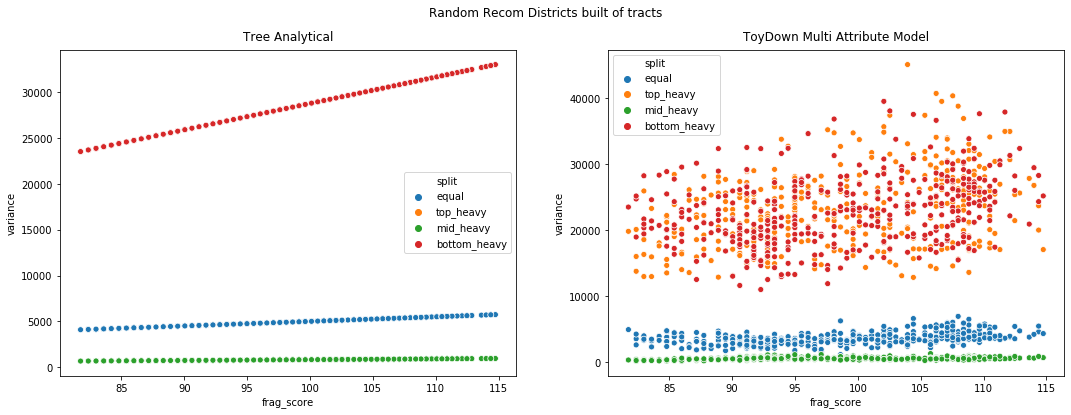

In [29]:
fig, axs = plt.subplots(1,2, figsize=(18,6))

fig.suptitle("Random Recom Districts built of tracts")
sns.scatterplot(data=tract_recom.query("analytical"), x="frag_score", y="variance", hue="split", ax=axs[0])
sns.scatterplot(data=tract_recom.query("not analytical"), x="frag_score", y="variance", hue="split", ax=axs[1])

pad = 5
for ax, col in zip(axs, ["Tree Analytical","ToyDown Multi Attribute Model"]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
plt.savefig("plots/dallas_county_tract_recom_districts_by_model_frag_vs_var.png", dpi=200, bbox_inches="tight")
plt.show()

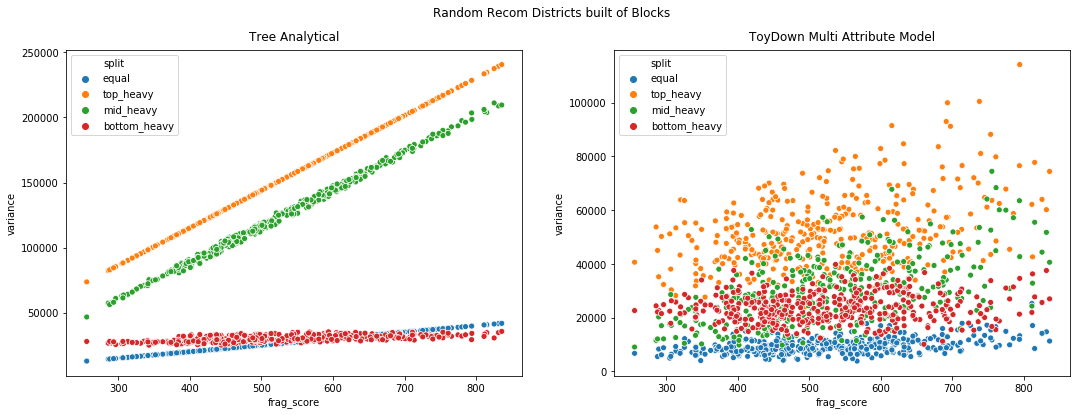

In [30]:
fig, axs = plt.subplots(1,2, figsize=(18,6))

fig.suptitle("Random Recom Districts built of Blocks")
sns.scatterplot(data=block_recom.query("analytical"), x="frag_score", y="variance", hue="split", ax=axs[0])
sns.scatterplot(data=block_recom.query("not analytical"), x="frag_score", y="variance", hue="split", ax=axs[1])

pad = 5
for ax, col in zip(axs, ["Tree Analytical","ToyDown Multi Attribute Model"]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
plt.savefig("plots/dallas_county_block_recom_districts_by_model_frag_vs_var.png", dpi=200, bbox_inches="tight")
plt.show()

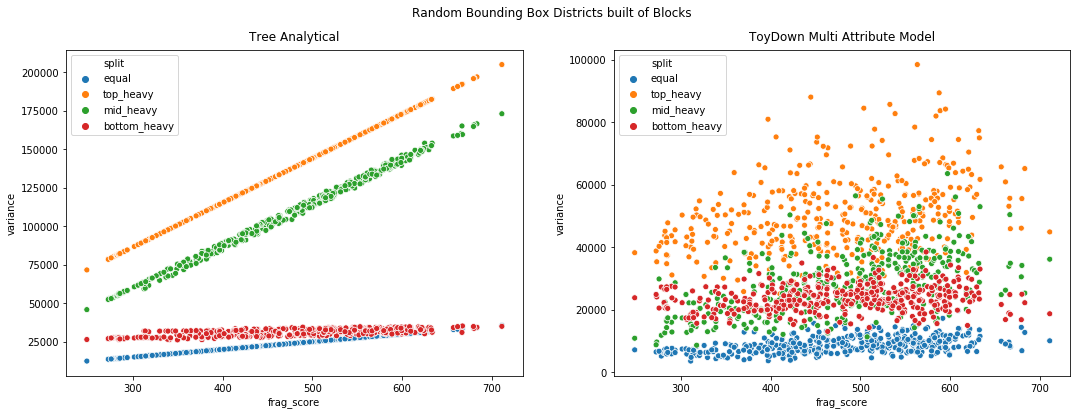

In [101]:
fig, axs = plt.subplots(1,2, figsize=(18,6))

fig.suptitle("Random Bounding Box Districts built of Blocks")
sns.scatterplot(data=block_bb.query("analytical"), x="frag_score", y="variance", hue="split", ax=axs[0])
sns.scatterplot(data=block_bb.query("not analytical"), x="frag_score", y="variance", hue="split", ax=axs[1])

pad = 5
for ax, col in zip(axs, ["Tree Analytical","ToyDown Multi Attribute Model"]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
plt.savefig("plots/dallas_county_block_bb_districts_by_model_frag_vs_var.png", dpi=200, bbox_inches="tight")
plt.show()

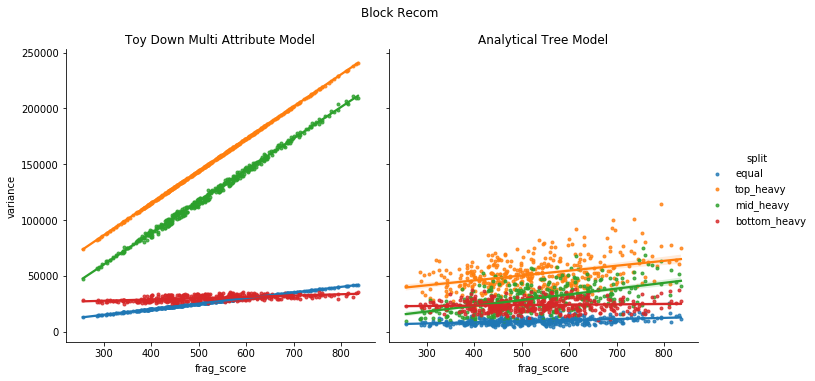

In [43]:
fig = sns.lmplot(data=block_recom, x="frag_score", y="variance", 
                 hue="split", col="analytical", markers=".", col_order=[True, False])
fig.fig.axes[0].set_title("Toy Down Multi Attribute Model")
fig.fig.axes[1].set_title("Analytical Tree Model")
fig.fig.suptitle("Block Recom", y=1.05)
plt.savefig("plots/dallas_county_block_recom_districts_by_model_frag_vs_var_fix_axis.png", 
            dpi=200, bbox_inches="tight")
plt.show()

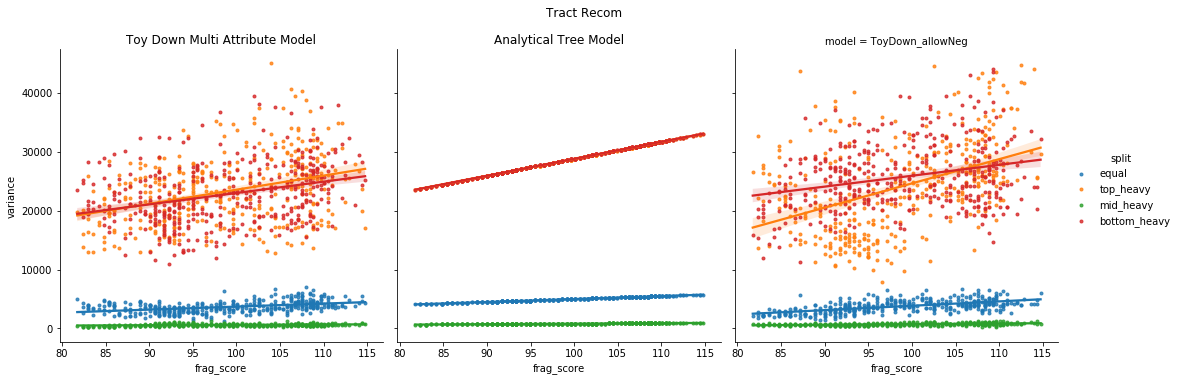

In [40]:
fig = sns.lmplot(data=df, x="frag_score", y="variance", 
           hue="split", col="analytical", markers=".", col_order=[True, False])
fig.fig.axes[0].set_title("Toy Down Multi Attribute Model")
fig.fig.axes[1].set_title("Analytical Tree Model")
fig.fig.suptitle("Tract Recom", y=1.05)
# plt.savefig("plots/dallas_county_tract_recom_districts_by_model_frag_vs_var_fix_axis.png", 
#             dpi=200, bbox_inches="tight")
plt.show()

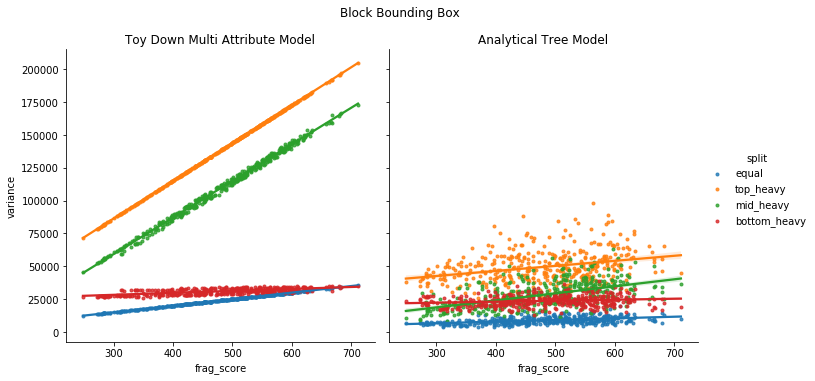

In [100]:
fig = sns.lmplot(data=block_bb, x="frag_score", y="variance", 
           hue="split", col="analytical", markers=".", col_order=[True, False])
fig.fig.axes[0].set_title("Toy Down Multi Attribute Model")
fig.fig.axes[1].set_title("Analytical Tree Model")
fig.fig.suptitle("Block Bounding Box", y=1.05)
plt.savefig("plots/dallas_county_block_bb_districts_by_model_frag_vs_var_fix_axis.png", 
            dpi=200, bbox_inches="tight")
plt.show()

In [108]:
block_bb.assign(dist="bb_block").append(block_recom.assign(dist="recom_block"))

,variance,frag_score,split,analytical,eps,dist
0,13217.190787,588.007074,equal,False,1,bb_block
1,7671.005616,402.118345,equal,False,1,bb_block
2,7065.548422,455.511223,equal,False,1,bb_block
3,4777.821562,451.452710,equal,False,1,bb_block
4,7251.614746,489.653148,equal,False,1,bb_block
...,...,...,...,...,...,...
3179,27661.612662,411.552377,bottom_heavy,True,1,recom_block
3180,33186.100855,413.838998,bottom_heavy,True,1,recom_block
3181,28603.507652,605.768556,bottom_heavy,True,1,recom_block
3182,26889.328180,461.119706,bottom_heavy,True,1,recom_block


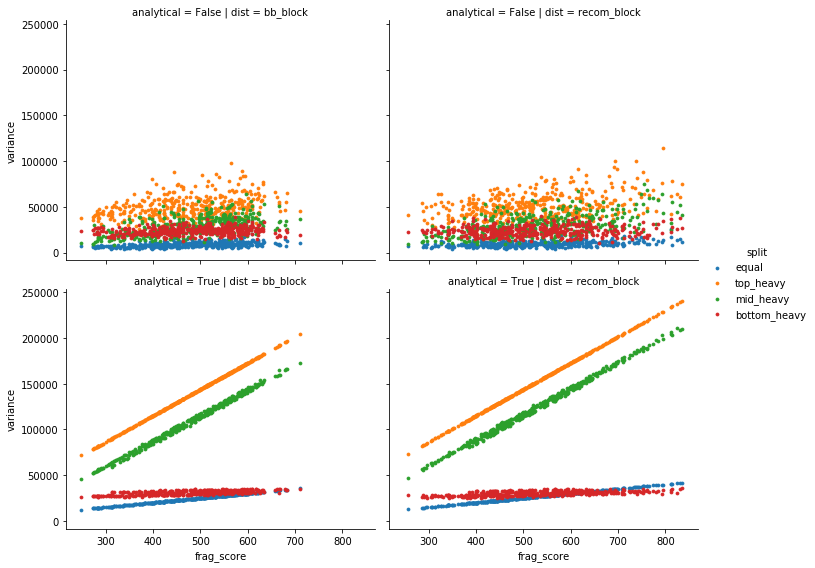

In [113]:
fig = sns.FacetGrid(block_bb.assign(dist="bb_block")
                    .append(block_recom.assign(dist="recom_block")),
#                     .append(tract_recom.assign(dist="recom_tract")), 
                    col="dist", row="analytical", hue="split",  height=4, aspect=1.25)
fig = (fig.map(sns.scatterplot, "frag_score", "variance", 
                   marker=".", edgecolor=None).add_legend())

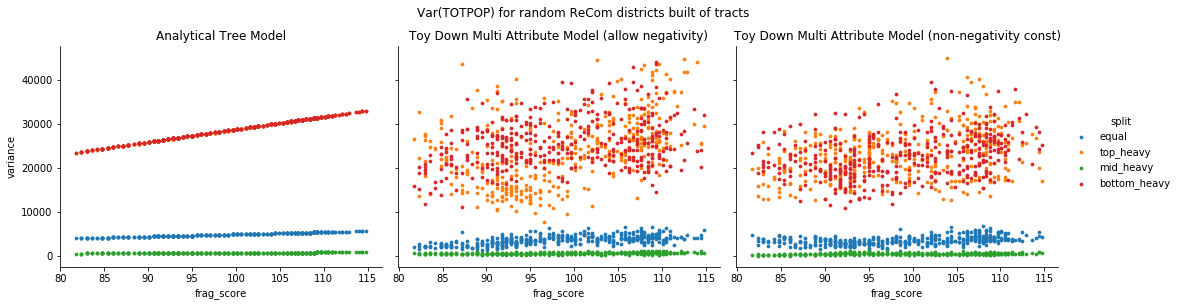

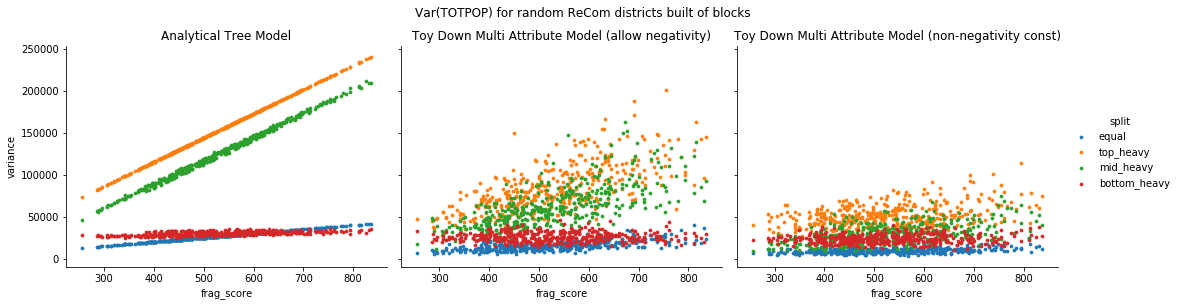

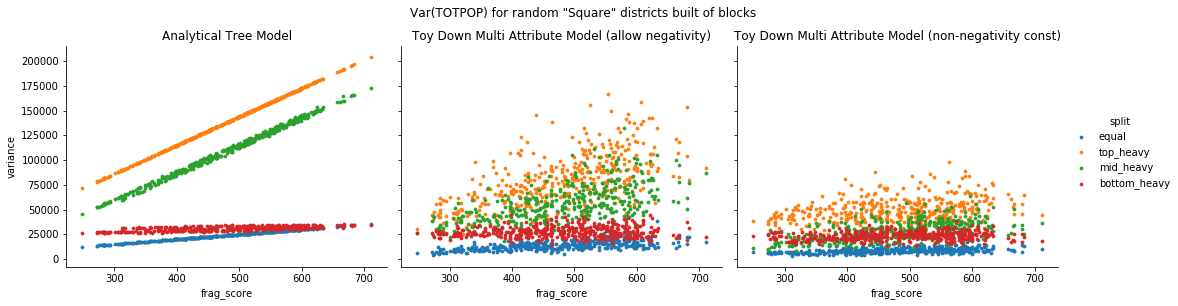

In [72]:
for data, title in [(tract_recom, "Var(TOTPOP) for random ReCom districts built of tracts"),
                    (block_recom, "Var(TOTPOP) for random ReCom districts built of blocks"), 
                    (block_bb, "Var(TOTPOP) for random \"Square\" districts built of blocks")]:
    fig = sns.FacetGrid(data, col="model",  hue="split", 
                        col_order=["tree_analytical", "ToyDown_allowNeg", "ToyDown_nonNeg"], height=4, aspect=1.25)
    fig = (fig.map(sns.scatterplot, "frag_score", "variance", 
                   marker=".", edgecolor=None).add_legend())
    fig.fig.axes[0].set_title("Analytical Tree Model")
    fig.fig.axes[1].set_title("Toy Down Multi Attribute Model (allow negativity)")
    fig.fig.axes[2].set_title("Toy Down Multi Attribute Model (non-negativity const)")
    fig.fig.suptitle(title, y=1.05)
    plt.savefig("plots/dallas_county_frag_vs_var_fixed_axis_{}_add_neg_vals.png".format(title.replace(' ', '_')), 
            dpi=200, bbox_inches="tight")
    plt.show()

In [111]:
d = tract_dists["dicts"][1]
h.assign_district_tree_variance(d, eps=1, eps_splits=epsilon_split["top_heavy"])

30951.11581219355

In [112]:
d = tract_dists["dicts"][1]
h.assign_district_tree_variance(d, eps=1, eps_splits=epsilon_split["bottom_heavy"])

30973.628596238777

In [196]:
epsilon_split_test = {"top_heavy": [2, 1, 1/2, 1,1],
                      "bottom_heavy": [1/8, 1/8, 1/2, 1, 1]}

In [197]:
for i in range(10):
    d = tract_dists["dicts"][i]
    frag = h.assign_district_tree_variance(d,eps=1, eps_splits=[np.sqrt(2)]*5)
    top = h.assign_district_tree_variance(d, eps=1, eps_splits=epsilon_split_test["top_heavy"])
    bot = h.assign_district_tree_variance(d, eps=1, eps_splits=epsilon_split_test["bottom_heavy"])
    print("{}:\ttop_heavy: {}\tbottom_heavy: {}\tfrag: {}".format(i, top, bot, frag))

0:	top_heavy: 800.4857687043694	bottom_heavy: 808.6668072226709	frag: 100.12087578303368
1:	top_heavy: 859.7755511165304	bottom_heavy: 870.0269081371243	frag: 107.54732151471774
2:	top_heavy: 804.418196404381	bottom_heavy: 812.721795591062	frag: 100.61333042692027
3:	top_heavy: 737.870292416056	bottom_heavy: 744.3222687168841	frag: 92.28122755421896
4:	top_heavy: 804.4181964043861	bottom_heavy: 812.7217955910671	frag: 100.61333042692091
5:	top_heavy: 678.0994707708965	bottom_heavy: 683.2187706590472	frag: 84.80007575730434
6:	top_heavy: 763.7330216086975	bottom_heavy: 770.8520195396655	frag: 95.518973274109
7:	top_heavy: 742.2563527145775	bottom_heavy: 748.8172212077576	frag: 92.83028576941909
8:	top_heavy: 842.0791538766537	bottom_heavy: 851.6584774925642	frag: 105.33033043763987
9:	top_heavy: 883.2803359765091	bottom_heavy: 894.5108114965366	frag: 110.4926190229462


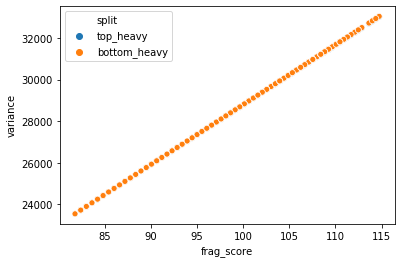

In [121]:
sns.scatterplot(data=tract_recom.query("analytical and split != 'equal' and split != 'mid_heavy'"), x="frag_score", y="variance", hue="split")

In [140]:
df = tract_recom.query("analytical and split != 'equal' and split != 'mid_heavy' and frag_score < 90")

In [141]:
df

,variance,frag_score,split,analytical,eps
5,24411.179434,84.800076,top_heavy,True,1
10,24583.223330,85.398190,top_heavy,True,1
23,24754.178437,85.992531,top_heavy,True,1
30,24063.825272,83.592526,top_heavy,True,1
35,23888.515007,82.983090,top_heavy,True,1
...,...,...,...,...,...
386,24422.421818,84.800076,bottom_heavy,True,1
389,25272.839019,87.752913,bottom_heavy,True,1
390,23722.525863,82.369881,bottom_heavy,True,1
391,24594.678835,85.398190,bottom_heavy,True,1


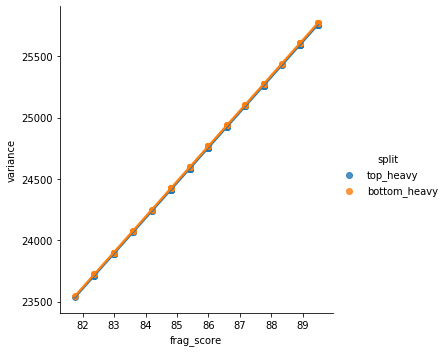

In [152]:
sns.lmplot(data=df, x="frag_score", y="variance", hue="split")
plt.savefig("test.png")

In [282]:
y

array([0.01      , 0.11888889, 0.22777778, 0.33666667, 0.44555556,
       0.55444444, 0.66333333, 0.77222222, 0.88111111, 0.99      ])

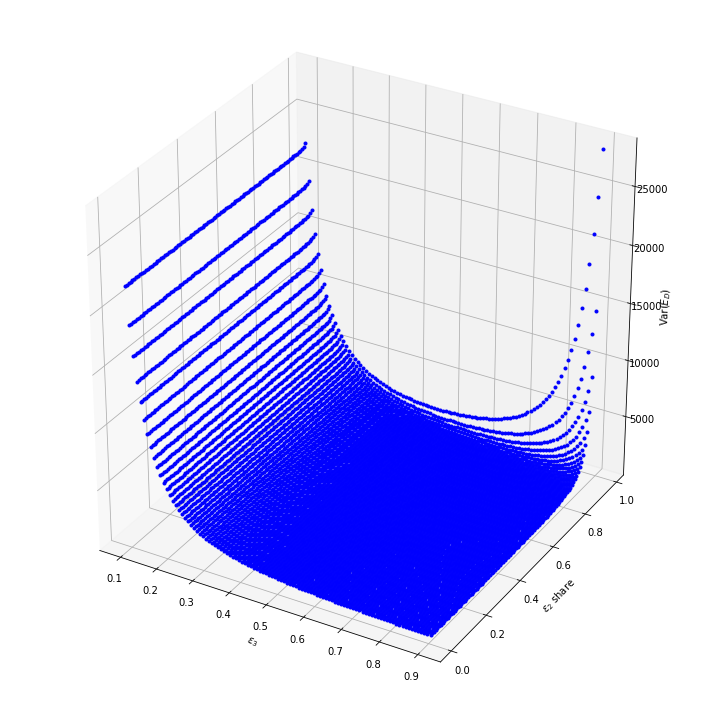

In [323]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0.1, 0.9, 100)
y = np.linspace(0.01, 0.975, 100)
X, e2_share = np.meshgrid(x, y)

Z = h.assign_district_tree_variance(d,eps=1, 
                                    eps_splits=[(1 - X)*(1 - e2_share),
                                                (1 - X)*e2_share, 
                                                X,1,1])

# plot the mesh. Each array is 2D, so we flatten them to 1D arrays
ax.plot(X.flatten(),
        e2_share.flatten(),
        Z.flatten(), 'b.')

# adjust the view so we can see the point/plane alignment
# ax.view_init(0, 22)
ax.set_xlabel("$\epsilon_3$")
ax.set_ylabel("$\epsilon_2$ share")
ax.set_zlabel("Var($E_D$)")
plt.tight_layout()
plt.show()

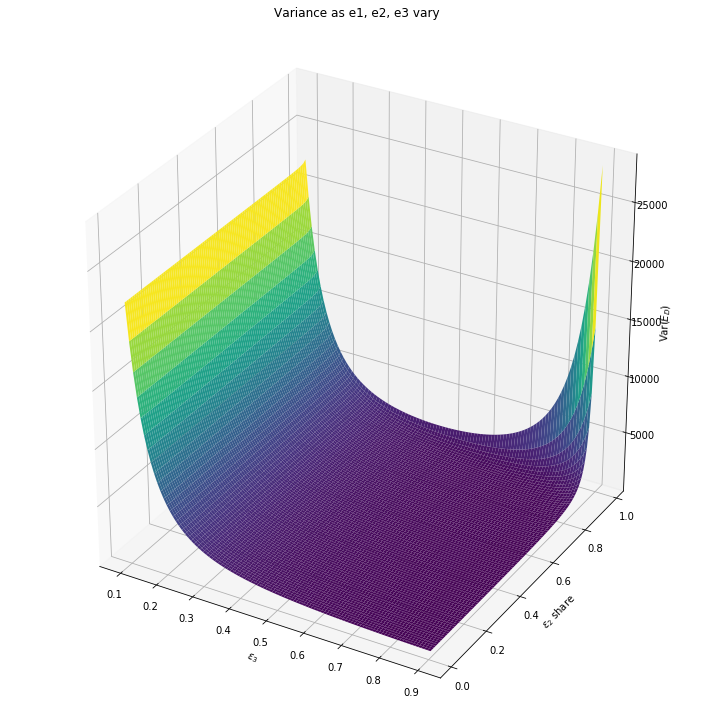

In [342]:
from matplotlib import cm
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0.1, 0.9, 100)
y = np.linspace(0.01, 0.975, 100)
X, e2_share = np.meshgrid(x, y)

Z = h.assign_district_tree_variance(d,eps=1, 
                                    eps_splits=[(1 - X)*(1 - e2_share),
                                                (1 - X)*e2_share, 
                                                X,1,1])

ax.plot_surface(X, e2_share, Z, cmap='viridis',edgecolor='none', rstride=1, cstride=1,)

# adjust the view so we can see the point/plane alignment
# ax.view_init(0, 22)
plt.tight_layout()
ax.set_title("Variance as e1, e2, e3 vary")
ax.set_xlabel("$\epsilon_3$")
ax.set_ylabel("$\epsilon_2$ share")
ax.set_zlabel("Var($E_D$)")
plt.savefig("var_plot.png")
plt.show()